In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import re
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [4]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets

# set the inputs
reco_versions = ["evtgen_v3_rec_v5"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)

In [5]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [6]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/evtgen/plots"
os.system(f"mkdir -p {plotting_path}")

0

In [7]:
# weight functions
spline_file = '/data/ana/Diffuse/NNMFit/MCEq_splines/v1.2.1/MCEq_splines_PRI-Gaisser-H4a_INT-SIBYLL23c_allfluxes.pickle'

# conventional            
flux_keys_conv =  ['conv_antinumu','conv_numu','conv_antinue','conv_nue','conv_antinutau','conv_nutau']
spline_object_conv = SplineHandler(spline_file, flux_keys_conv)
conv_flux = spline_object_conv.return_weight
generator_conv = lambda pdgid, energy, cos_zen: conv_flux(pdgid, energy, cos_zen)

# prompt
flux_keys_pr =  ['pr_antinumu','pr_numu','pr_antinue','pr_nue','pr_antinutau','pr_nutau']
spline_object_pr = SplineHandler(spline_file, flux_keys_pr)
pr_flux = spline_object_pr.return_weight
generator_pr = lambda pdgid, energy, cos_zen: pr_flux(pdgid, energy, cos_zen)

# astro
gamma_astro = 2.87
per_flavor_norm = 2.12
def AstroFluxModel(pdgid, energy, cos_zen):
    flux = 0.5*(per_flavor_norm*1e-18)*(energy/1e5)**-gamma_astro
    return flux

In [8]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    # calculate weights
    for key in simulation_dataset:
        simulation_dataset[key]['weights_astro'] = simulation_dataset[key]["weighter"].get_weights(AstroFluxModel) * livetime_s
        simulation_dataset[key]['weights_conv'] = simulation_dataset[key]["weighter"].get_weights(generator_conv) * livetime_s
        simulation_dataset[key]['weights_pr'] = simulation_dataset[key]["weighter"].get_weights(generator_pr) * livetime_s


    return simulation_dataset



In [10]:
keys_to_merge = {}

keys_to_merge["evtgen_v3_rec_v5"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}


In [11]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau


In [12]:
dataset_label_dict = {
    "evtgen_v3_rec_v5" : "ftp-v3",
    "spice_tau_reco" : "spice v3.2.1",
}

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

Tianlu asked me to add some selections, lets do that

In [14]:
classifications = {}

classifications["All"] = {
    "variables": [("RecoETot", "value")],  # (variable_name, column_type)
    "cut_functions": {
        "All": lambda vars: (vars["RecoETot"] > 1e4),
    }
}

# classifications["cc.length < 5"] = {
#     "variables": [("cc", "length")],  # (variable_name, column_type)
#     "cut_functions": {
#         "All": lambda vars: (vars["cc"] < 5),
#     }
# }


# classifications["5 < cc.length < 20"] = {
#     "variables": [("cc", "length")],  # (variable_name, column_type)
#     "cut_functions": {
#         "All": lambda vars: (vars["cc"] > 5) & (vars["cc"] < 20),
#     }
# }


# classifications["20 < cc.length < 40"] = {
#     "variables": [("cc", "length")],  # (variable_name, column_type)
#     "cut_functions": {
#         "All": lambda vars: (vars["cc"] > 20) & (vars["cc"] < 40),
#     }
# }

# classifications["cc.length > 40"] = {
#     "variables": [("cc", "length")],  # (variable_name, column_type)
#     "cut_functions": {
#         "All": lambda vars: (vars["cc"] > 40),
#     }
# }

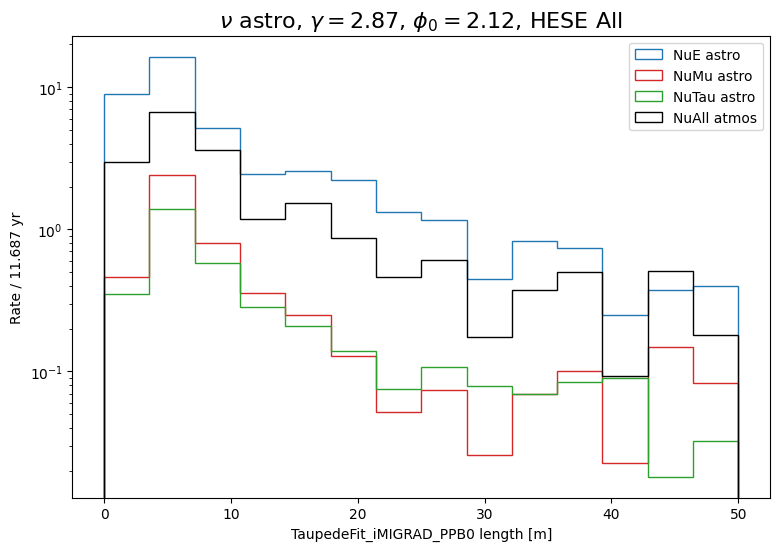

In [ ]:
def oneD_event_rate( dataset_key = "spice_tau_reco",
                        var_key1 = "I3MCWeightDict", 
                        var_key2 = "PrimaryNeutrinoEnergy",
                        classification_name = "All",
                        xlabel    = "PrimaryNeutrinoEnergy [GeV]",
                        bins = np.geomspace(1e4, 1e6, 20),
                        xscale = "log", yscale = "log",
                        savename = "PrimaryNeutrinoEnergy.pdf"):

    colors = ["C0","C3","C2"]

    # Compute bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    fig, ax = plt.subplots(figsize=(9, 6))  # one normal plot
    ax.set_title(rf"$\nu$ astro, $\gamma = 2.87$, $\phi_0=2.12$, HESE {classification_name}", fontsize=16)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_ylabel(f"Rate / {livetime_yr} yr") 
    ax.set_xlabel(f"{xlabel}") 

    classification = classifications[classification_name]

    for i,flavor in enumerate(["NuE","NuMu","NuTau"]):
        var = simulation_datasets[dataset_key][flavor]["weighter"].get_column(var_key1, var_key2)
        
        classification_variables = {
        var: simulation_datasets[dataset_key][flavor]["weighter"].get_column(var, col_type)
        for var, col_type in classification["variables"]
        }
        
        # Apply the cut function, passing the variables dict
        mask = classification["cut_functions"]["All"](classification_variables)
        var = var[mask]
        weights = simulation_datasets[dataset_key][flavor]["weights_astro"][mask]

        # Compute histograms
        hist, _  = np.histogram(var,weights=weights,bins=bins )

        ax.hist(var, weights=weights, bins=bins, histtype="step", color=colors[i], linestyle="-",label = rf"{flavor} astro")


    # atmos neutrinos
    flavor = "NuAll"
    var = simulation_datasets[dataset_key][flavor]["weighter"].get_column(var_key1, var_key2)
    
    classification_variables = {
    var: simulation_datasets[dataset_key][flavor]["weighter"].get_column(var, col_type)
    for var, col_type in classification["variables"]
    }
    
    # Apply the cut function, passing the variables dict
    mask = classification["cut_functions"]["All"](classification_variables)
    var = var[mask]
    weights = (simulation_datasets[dataset_key][flavor]["weights_conv"] + \
               simulation_datasets[dataset_key][flavor]["weights_pr"]    )[mask]

    # Compute histograms
    hist, _  = np.histogram(var,weights=weights,bins=bins )

    ax.hist(var, weights=weights, bins=bins, histtype="step", color="black", linestyle="-",label = rf"{flavor} atmos")

    ax.legend()

    plt.savefig(f"{plotting_path}/{savename}")

    plt.show()


# # test
# oneD_event_rate(  dataset_key = "evtgen_v3_rec_v5",
#                     var_key1 = "TaupedeFit_iMIGRAD_PPB0", 
#                     var_key2 = "length",
#                     classification_name="All",
#                     bins = np.linspace(0, 50, 15),
#                     xlabel="TaupedeFit_iMIGRAD_PPB0 length [m]",
#                     xscale = "linear", yscale = "log",
#                     savename = "test.pdf" )


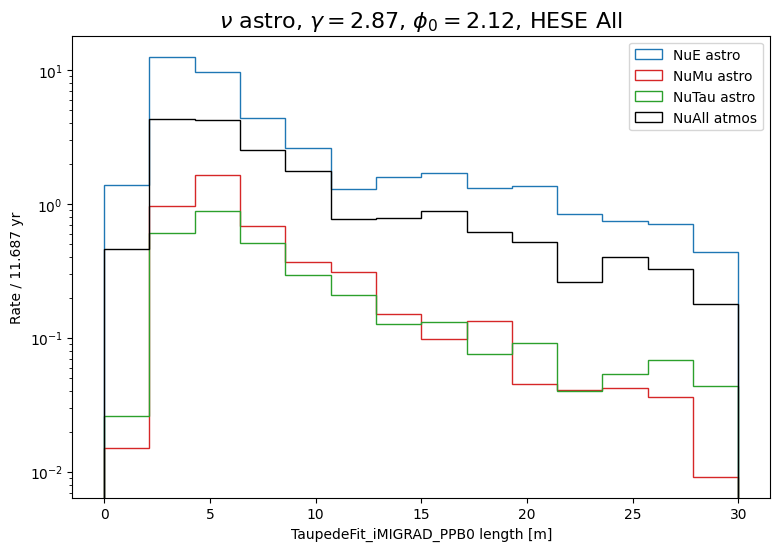

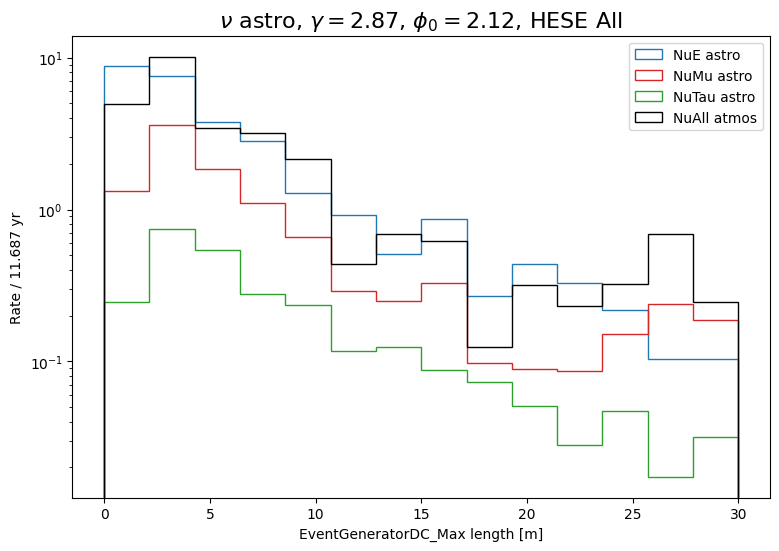

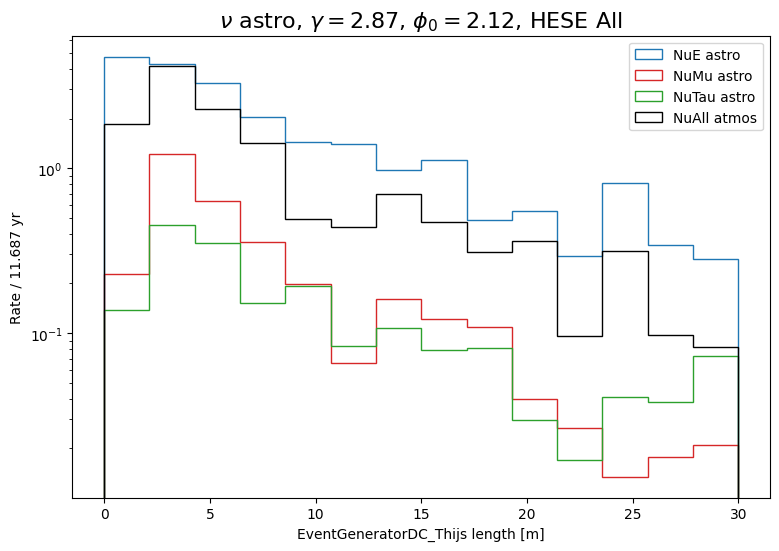

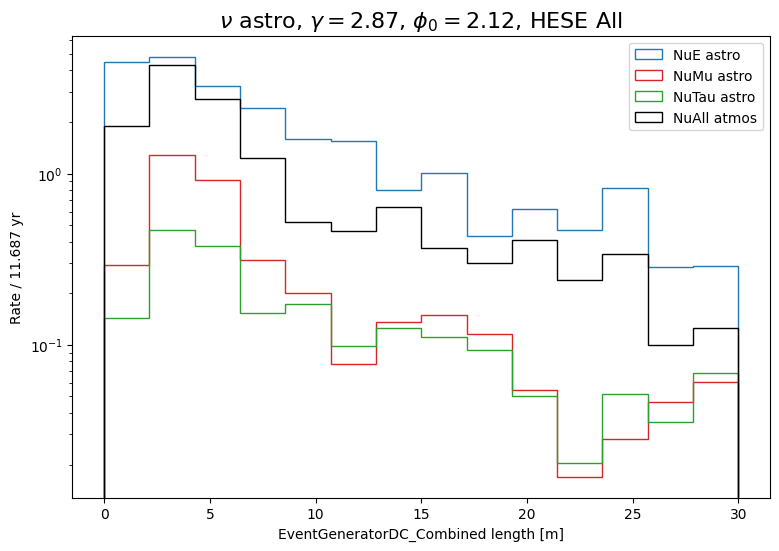

In [33]:
for fit_object,variable in zip(["TaupedeFit_iMIGRAD_PPB0", 'EventGeneratorDC_Max', 'EventGeneratorDC_Thijs', 'EventGeneratorDC_Combined'],
                               ["length","cascade_cascade_00001_distance","cascade_cascade_00001_distance","cascade_cascade_00001_distance"]):
    oneD_event_rate(  dataset_key = "evtgen_v3_rec_v5",
                        var_key1 = fit_object, 
                        var_key2 = variable,
                        classification_name="All",
                        bins = np.linspace(0, 30, 15),
                        xlabel=f"{fit_object} length [m]",
                        xscale = "linear", yscale = "log",
                        savename = f"{fit_object}.pdf" )